In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import os

# Import custom data loader
from drive_dataloader import DRIVEDataLoader

print("✅ All libraries loaded!")


✅ All libraries loaded!


In [2]:
loader = DRIVEDataLoader(dataset_path='./datasets/DRIVE')

# Get all available images
training_images = loader.get_all_training_images()
print(f"📸 Found {len(training_images)} training images")
print(f"Sample images: {training_images[:5]}")

📸 Found 20 training images
Sample images: ['21_training.tif', '22_training.tif', '23_training.tif', '24_training.tif', '25_training.tif']



✅ Loaded: 21_training.tif
Shape: (584, 565)
Data type: uint8
Min-Max pixel values: 0-243


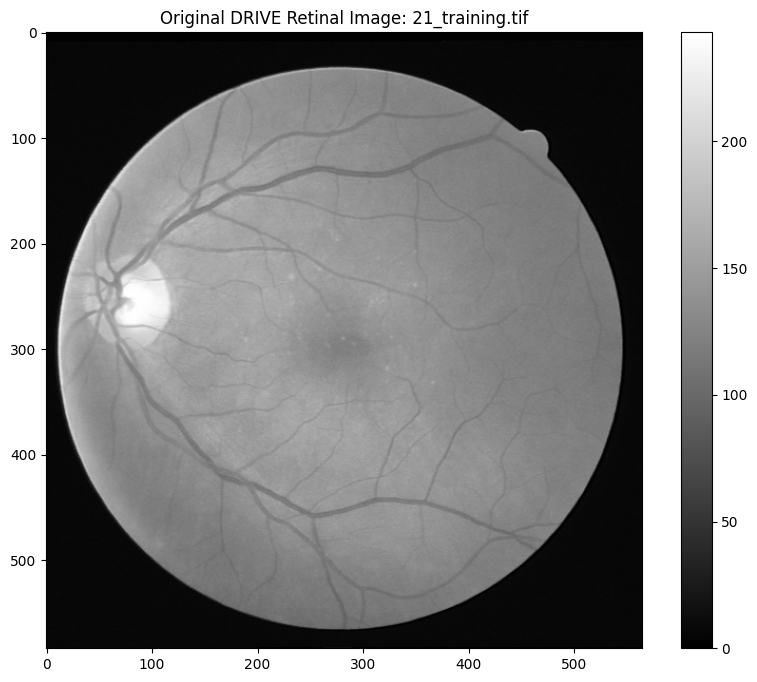

In [3]:
# Cell 3: Load Real DRIVE Retinal Image
# Pick first training image
image_name = training_images[0]
original_img = loader.load_image(image_name, image_type='training')

print(f"\n✅ Loaded: {image_name}")
print(f"Shape: {original_img.shape}")
print(f"Data type: {original_img.dtype}")
print(f"Min-Max pixel values: {original_img.min()}-{original_img.max()}")

# Display original
plt.figure(figsize=(10, 8))
plt.imshow(original_img, cmap='gray')
plt.title(f"Original DRIVE Retinal Image: {image_name}")
plt.colorbar()
plt.show()

✅ Noise added!
Noise density: 2%


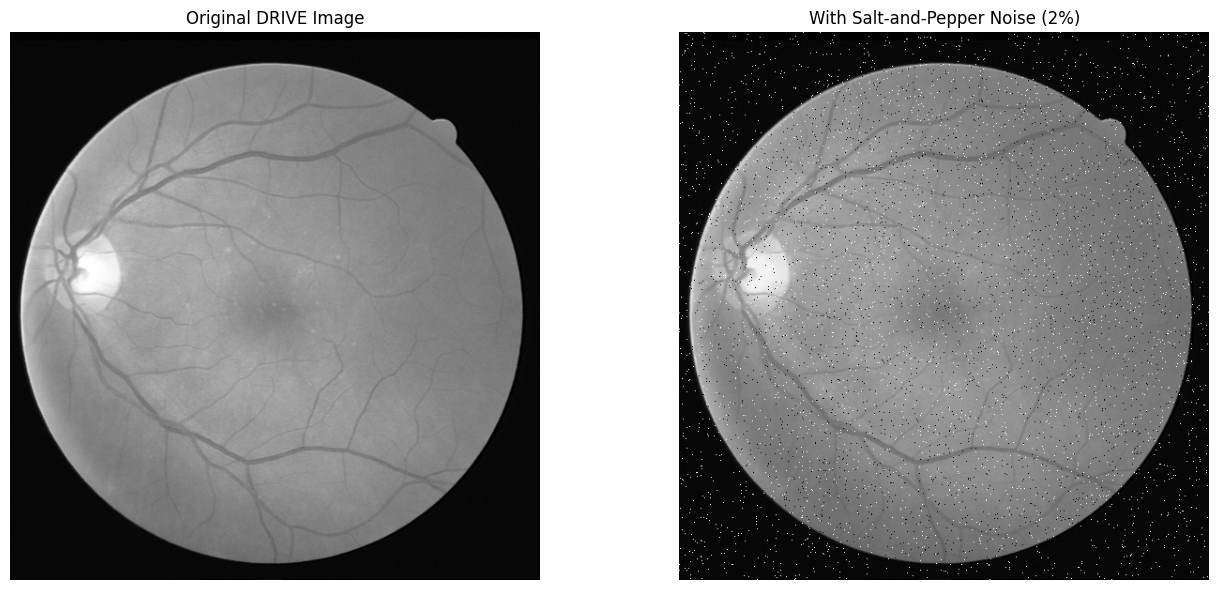

In [4]:

# Cell 4: Add Salt-and-Pepper Noise
def add_salt_pepper_noise(img, noise_density=0.02):
    """Real DRIVE image mein noise add karo"""
    noisy_img = img.copy().astype(float)
    h, w = img.shape
    total_pixels = h * w
    
    # Calculate number of salt and pepper pixels
    num_salt = int(total_pixels * noise_density / 2)
    num_pepper = int(total_pixels * noise_density / 2)
    
    # Add salt (white pixels = 255)
    salt_coords = (
        np.random.randint(0, h, num_salt),
        np.random.randint(0, w, num_salt)
    )
    noisy_img[salt_coords] = 255
    
    # Add pepper (black pixels = 0)
    pepper_coords = (
        np.random.randint(0, h, num_pepper),
        np.random.randint(0, w, num_pepper)
    )
    noisy_img[pepper_coords] = 0
    
    return noisy_img.astype(np.uint8)

# Add noise (2% density - typical for salt-and-pepper)
noisy_img = add_salt_pepper_noise(original_img, noise_density=0.02)

print(f"✅ Noise added!")
print(f"Noise density: 2%")

# Display noisy vs original
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(original_img, cmap='gray')
axes[0].set_title("Original DRIVE Image")
axes[0].axis('off')

axes[1].imshow(noisy_img, cmap='gray')
axes[1].set_title("With Salt-and-Pepper Noise (2%)")
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [5]:
# Cell 5: Apply Denoising Filters
print("🔄 Applying denoising filters...\n")

# Median Filter
denoised_median = cv2.medianBlur(noisy_img, 5)
print("✅ Median Filter applied")

# Adaptive Median Filter (using scipy)
denoised_adaptive = median_filter(noisy_img, size=5).astype(np.uint8)
print("✅ Adaptive Median Filter applied")

# Bilateral Filter (edge-preserving)
denoised_bilateral = cv2.bilateralFilter(noisy_img, 9, 75, 75)
print("✅ Bilateral Filter applied")

# Morphological Closing (for connected components)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
opening = cv2.morphologyEx(noisy_img, cv2.MORPH_OPEN, kernel)
denoised_morpho = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
print("✅ Morphological Filter applied")

🔄 Applying denoising filters...

✅ Median Filter applied
✅ Adaptive Median Filter applied
✅ Bilateral Filter applied
✅ Morphological Filter applied


In [6]:
# Cell 6: Calculate Quality Metrics (PSNR & SSIM)
print("\n📊 Calculating metrics...\n")

metrics = {}

for filter_name, denoised in [
    ('Median (k=5)', denoised_median),
    ('Adaptive Median (k=5)', denoised_adaptive),
    ('Bilateral', denoised_bilateral),
    ('Morphological', denoised_morpho)
]:
    psnr_val = psnr(original_img, denoised, data_range=255)
    ssim_val = ssim(original_img, denoised, data_range=255)
    
    metrics[filter_name] = {'psnr': psnr_val, 'ssim': ssim_val}
    print(f"{filter_name:25} | PSNR: {psnr_val:6.2f} dB | SSIM: {ssim_val:6.4f}")


📊 Calculating metrics...

Median (k=5)              | PSNR:  40.37 dB | SSIM: 0.9480
Adaptive Median (k=5)     | PSNR:  40.33 dB | SSIM: 0.9479
Bilateral                 | PSNR:  25.76 dB | SSIM: 0.7684
Morphological             | PSNR:  35.92 dB | SSIM: 0.9252


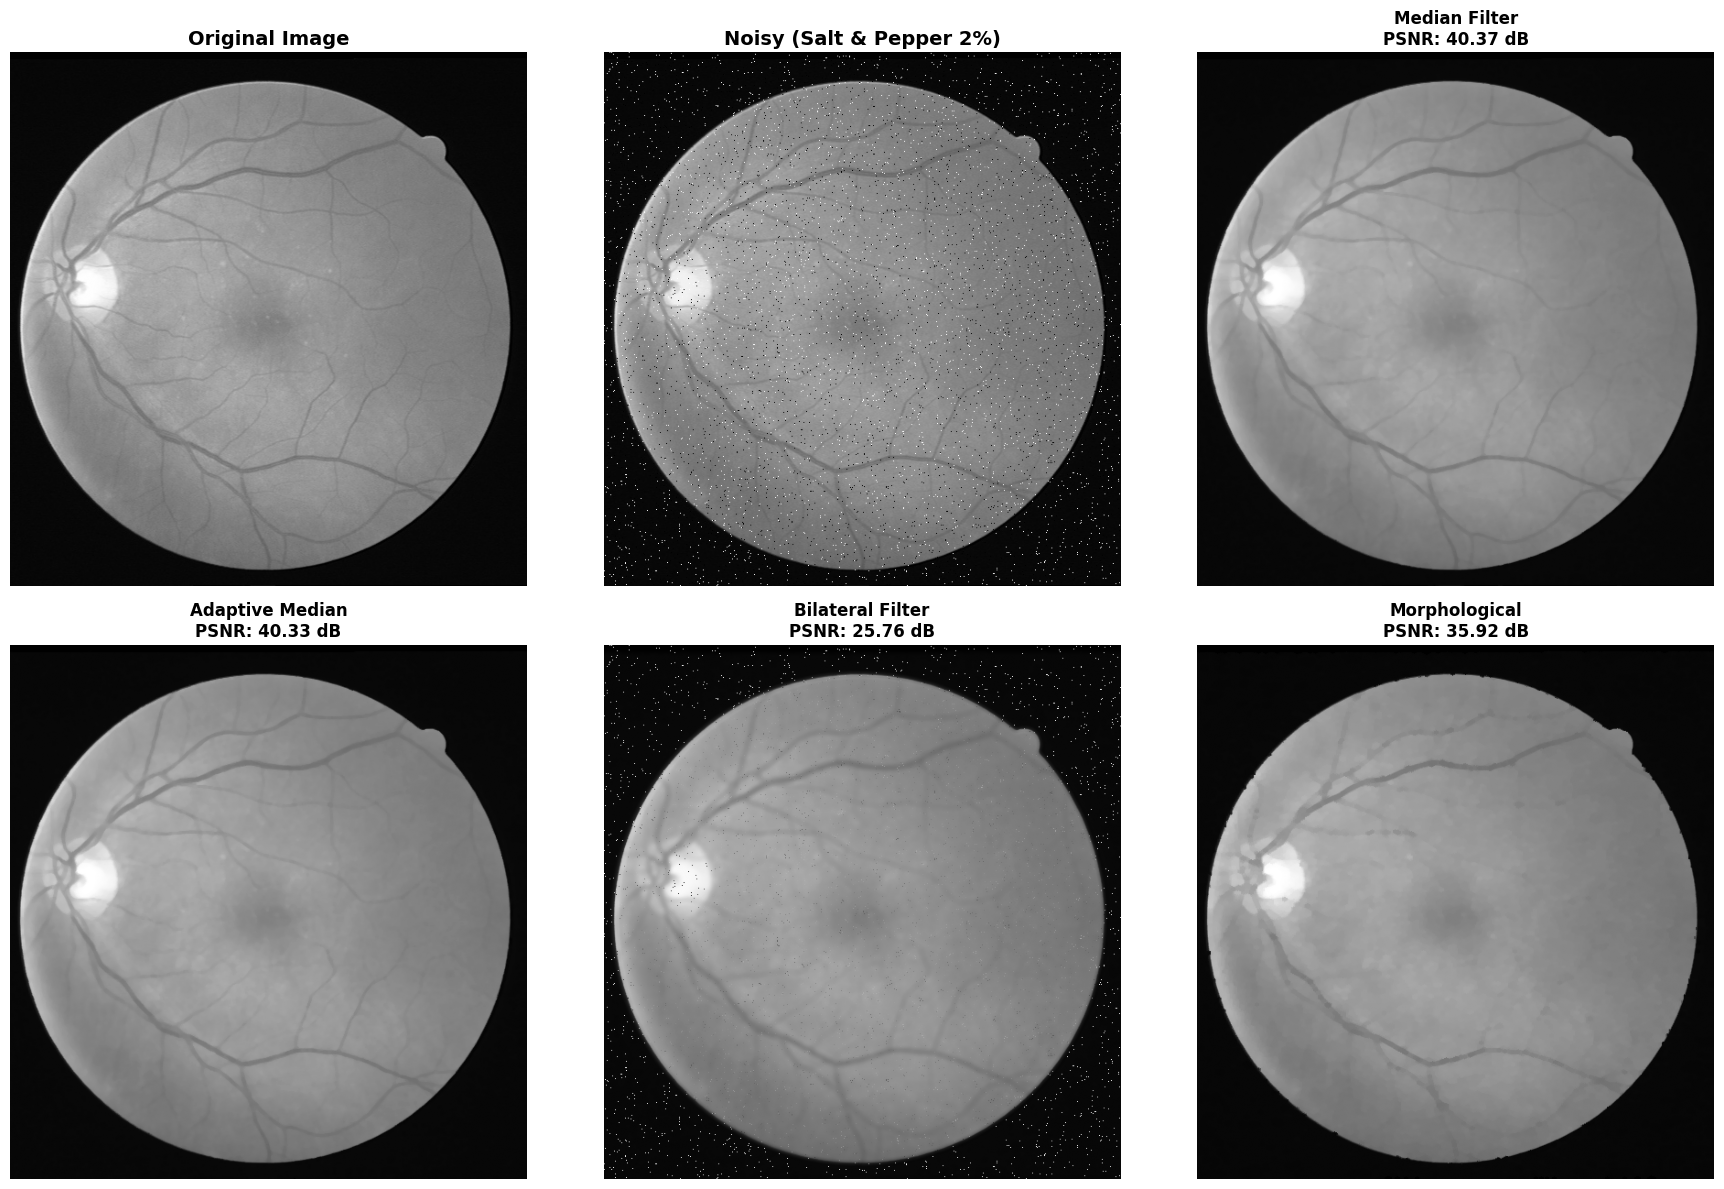

In [7]:
# Cell 7: Visualize All Results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1
axes[0, 0].imshow(original_img, cmap='gray')
axes[0, 0].set_title("Original Image", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(noisy_img, cmap='gray')
axes[0, 1].set_title("Noisy (Salt & Pepper 2%)", fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(denoised_median, cmap='gray')
axes[0, 2].set_title(f"Median Filter\nPSNR: {metrics['Median (k=5)']['psnr']:.2f} dB", 
                      fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Row 2
axes[1, 0].imshow(denoised_adaptive, cmap='gray')
axes[1, 0].set_title(f"Adaptive Median\nPSNR: {metrics['Adaptive Median (k=5)']['psnr']:.2f} dB", 
                     fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(denoised_bilateral, cmap='gray')
axes[1, 1].set_title(f"Bilateral Filter\nPSNR: {metrics['Bilateral']['psnr']:.2f} dB", 
                     fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(denoised_morpho, cmap='gray')
axes[1, 2].set_title(f"Morphological\nPSNR: {metrics['Morphological']['psnr']:.2f} dB", 
                     fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [8]:
best_filter = max(metrics, key=lambda x: metrics[x]['psnr'])
print(f"\n🏆 Best Filter: {best_filter}")
print(f"   PSNR: {metrics[best_filter]['psnr']:.2f} dB")
print(f"   SSIM: {metrics[best_filter]['ssim']:.4f}")


🏆 Best Filter: Median (k=5)
   PSNR: 40.37 dB
   SSIM: 0.9480


In [9]:

# Cell 9: Save Results
output_dir = './datasets/results'
os.makedirs(output_dir, exist_ok=True)

cv2.imwrite(f'{output_dir}/01_original.jpg', original_img)
cv2.imwrite(f'{output_dir}/02_noisy.jpg', noisy_img)
cv2.imwrite(f'{output_dir}/03_median.jpg', denoised_median)
cv2.imwrite(f'{output_dir}/04_adaptive.jpg', denoised_adaptive)
cv2.imwrite(f'{output_dir}/05_bilateral.jpg', denoised_bilateral)
cv2.imwrite(f'{output_dir}/06_morphological.jpg', denoised_morpho)

print(f"\n✅ Results saved to: {output_dir}")


✅ Results saved to: ./datasets/results


In [10]:

# Cell 10: Test with Multiple Images
print("\n🔄 Testing with all training images...\n")

test_images = training_images[:5]  # First 5 images

results_summary = {img: {} for img in test_images}

for img_name in test_images:
    img = loader.load_image(img_name, image_type='training')
    noisy = add_salt_pepper_noise(img, noise_density=0.02)
    
    denoised = cv2.medianBlur(noisy, 5)  # Use median for speed
    psnr_val = psnr(img, denoised, data_range=255)
    
    results_summary[img_name]['psnr'] = psnr_val
    print(f"✅ {img_name}: PSNR = {psnr_val:.2f} dB")

print("\n✅ All tests completed successfully!")


🔄 Testing with all training images...

✅ 21_training.tif: PSNR = 40.39 dB
✅ 22_training.tif: PSNR = 40.24 dB
✅ 23_training.tif: PSNR = 41.77 dB
✅ 24_training.tif: PSNR = 40.54 dB
✅ 25_training.tif: PSNR = 41.89 dB

✅ All tests completed successfully!
